In [1]:
from google.colab import files
uploaded = files.upload()

Saving df_F.csv to df_F.csv


In [32]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import torch

In [73]:
import pandas as pd

DATA = "df_F.csv"
df = pd.read_csv(DATA, sep=";")
df.columns

Index(['day_tempmax', 'day_tempmin', 'day_temp', 'day_dew', 'day_humidity',
       'day_precip', 'day_precipcover', 'day_solarradiation',
       'day_solarenergy', 'day_uvindex', 'day_sunrise', 'day_sunset',
       'day_moonphase', 'hour_temp', 'hour_humidity', 'hour_dew',
       'hour_precip', 'hour_precipprob', 'hour_snow', 'hour_snowdepth',
       'hour_windgust', 'hour_windspeed', 'hour_winddir', 'hour_pressure',
       'hour_visibility', 'hour_cloudcover', 'hour_solarradiation',
       'hour_solarenergy', 'hour_uvindex', 'region_id', 'is_alarm',
       'duration_hours', 'weather_Clear',
       'weather_Freezing Drizzle/Freezing Rain, Overcast',
       'weather_Ice, Overcast', 'weather_Overcast', 'weather_Partially cloudy',
       'weather_Rain', 'weather_Rain, Fog', 'weather_Rain, Overcast',
       'weather_Rain, Partially cloudy', 'weather_Snow',
       'weather_Snow, Overcast', 'weather_Snow, Partially cloudy',
       'weather_Snow, Rain', 'weather_Snow, Rain, Fog',
       'weat

In [74]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [75]:

def generate_sample_data(n_samples=1000):
    np.random.seed(42)

    timestamps = pd.date_range(start='2022-01-01', periods=n_samples, freq='H')

    df = pd.DataFrame({
        'day_datetime_timestamp': timestamps,
        'hour': timestamps.hour,
        'day_tempmax': np.random.uniform(10, 35, n_samples),
        'day_tempmin': np.random.uniform(0, 20, n_samples),
        'day_temp': np.random.uniform(5, 30, n_samples),
        'day_dew': np.random.uniform(-5, 15, n_samples),
        'day_humidity': np.random.uniform(30, 90, n_samples),
        'day_precip': np.random.exponential(1, n_samples),
        'day_precipcover': np.random.uniform(0, 100, n_samples),
        'day_solarradiation': np.random.uniform(0, 300, n_samples),
        'day_solarenergy': np.random.uniform(0, 20, n_samples),
        'day_uvindex': np.random.uniform(0, 10, n_samples),
        'day_sunrise': timestamps.hour - 6,
        'day_sunset': timestamps.hour + 6,
        'day_moonphase': np.random.uniform(0, 1, n_samples),
        'hour_temp': np.random.uniform(5, 30, n_samples),
        'hour_humidity': np.random.uniform(30, 90, n_samples),
        'hour_dew': np.random.uniform(-5, 15, n_samples),
        'hour_precip': np.random.exponential(0.5, n_samples),
        'hour_precipprob': np.random.uniform(0, 100, n_samples),
        'hour_snow': np.random.uniform(0, 5, n_samples),
        'hour_snowdepth': np.random.uniform(0, 10, n_samples),
        'hour_windgust': np.random.uniform(0, 40, n_samples),
        'hour_windspeed': np.random.uniform(0, 30, n_samples),
        'hour_winddir': np.random.uniform(0, 360, n_samples),
        'hour_pressure': np.random.uniform(980, 1030, n_samples),
        'hour_visibility': np.random.uniform(0, 10, n_samples),
        'hour_cloudcover': np.random.uniform(0, 100, n_samples),
        'hour_solarradiation': np.random.uniform(0, 300, n_samples),
        'hour_solarenergy': np.random.uniform(0, 20, n_samples),
        'hour_uvindex': np.random.uniform(0, 10, n_samples),
        'region_id': np.random.randint(1, 5, n_samples),
        'region_alt_encoded': np.random.uniform(0, 1000, n_samples),
        'duration_hours': np.random.randint(1, 24, n_samples)
    })

    pressure_factor = ((df['hour_pressure'] - 1010) / 10)
    rain_factor = df['hour_precip'] * 2
    wind_factor = df['hour_windspeed'] / 10

    prob = 1 / (1 + np.exp(-(pressure_factor + rain_factor + wind_factor)))
    df['is_alarm'] = (prob > 0.5).astype(int)

    df['was_alarm_event'] = ((df['is_alarm'] == 1) &
                            (df['hour_precip'] > np.percentile(df['hour_precip'], 70))).astype(int)

    weather_types = ['Clear', 'Overcast', 'Partially cloudy', 'Rain', 'Snow',
                    'Rain, Overcast', 'Snow, Overcast', 'Rain, Partially cloudy',
                    'Snow, Partially cloudy', 'Snow, Rain', 'Snow, Rain, Fog',
                    'Snow, Rain, Overcast', 'Snow, Rain, Partially cloudy',
                    'Rain, Fog', 'Freezing Drizzle/Freezing Rain, Overcast', 'Ice, Overcast']

    for weather_type in weather_types:
        col_name = f'weather_{weather_type}'
        df[col_name] = 0

    for i in range(len(df)):
        weather_type = np.random.choice(weather_types)
        df.loc[i, f'weather_{weather_type}'] = 1

    return df

In [77]:
alarm_data = df[df['is_alarm'] == 1]
no_alarm_data = df[df['is_alarm'] == 0]

for feature in df.select_dtypes(include=['float64', 'int64']).columns:
    if feature != 'is_alarm':
        print(f"\nФіча: {feature}")
        print(f"1: {alarm_data[feature].mean():.4f}")
        print(f"0: {no_alarm_data[feature].mean():.4f}")
        print(f"{abs(alarm_data[feature].mean() - no_alarm_data[feature].mean()):.4f}")


Фіча: day_tempmax
1: 15.7714
0: 15.1240
0.6475

Фіча: day_tempmin
1: 6.5120
0: 6.2282
0.2838

Фіча: day_temp
1: 11.1357
0: 10.6674
0.4683

Фіча: day_dew
1: 4.9984
0: 5.4141
0.4157

Фіча: day_humidity
1: 70.1235
0: 73.6122
3.4887

Фіча: day_precip
1: 2.0569
0: 2.0821
0.0251

Фіча: day_precipcover
1: 5.9160
0: 6.6357
0.7198

Фіча: day_solarradiation
1: 149.5011
0: 140.4199
9.0812

Фіча: day_solarenergy
1: 12.8970
0: 12.1094
0.7876

Фіча: day_uvindex
1: 5.0078
0: 4.7671
0.2407

Фіча: day_sunrise
1: 6.2486
0: 6.5131
0.2645

Фіча: day_sunset
1: 18.5397
0: 18.7600
0.2202

Фіча: day_moonphase
1: 0.4926
0: 0.4877
0.0049

Фіча: hour_temp
1: 11.0830
0: 10.6988
0.3841

Фіча: hour_humidity
1: 70.2361
0: 73.5143
3.2783

Фіча: hour_dew
1: 4.9957
0: 5.4134
0.4177

Фіча: hour_precip
1: 0.0877
0: 0.0862
0.0015

Фіча: hour_precipprob
1: 5.5609
0: 6.7435
1.1826

Фіча: hour_snow
1: 0.0039
0: 0.0053
0.0015

Фіча: hour_snowdepth
1: 0.4563
0: 0.6333
0.1770

Фіча: hour_windgust
1: 23.8583
0: 23.7769
0.0814



In [78]:
df = generate_sample_data(10000)

X = df.drop(['is_alarm', 'was_alarm_event', 'day_datetime_timestamp', 'duration_hours'], axis=1)
y_reg = df['is_alarm']
y_class = df['is_alarm']

feature_names = X.columns.tolist()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

tscv = TimeSeriesSplit(n_splits=5)

def train_linear_regression(X_train, y_train, X_test, y_test):
    model = LinearRegression()
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    return model, y_pred, rmse, mae, r2


<ipython-input-75-9cd853f3abe6>:4: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  timestamps = pd.date_range(start='2022-01-01', periods=n_samples, freq='H')


In [79]:
X.columns

Index(['hour', 'day_tempmax', 'day_tempmin', 'day_temp', 'day_dew',
       'day_humidity', 'day_precip', 'day_precipcover', 'day_solarradiation',
       'day_solarenergy', 'day_uvindex', 'day_sunrise', 'day_sunset',
       'day_moonphase', 'hour_temp', 'hour_humidity', 'hour_dew',
       'hour_precip', 'hour_precipprob', 'hour_snow', 'hour_snowdepth',
       'hour_windgust', 'hour_windspeed', 'hour_winddir', 'hour_pressure',
       'hour_visibility', 'hour_cloudcover', 'hour_solarradiation',
       'hour_solarenergy', 'hour_uvindex', 'region_id', 'region_alt_encoded',
       'weather_Clear', 'weather_Overcast', 'weather_Partially cloudy',
       'weather_Rain', 'weather_Snow', 'weather_Rain, Overcast',
       'weather_Snow, Overcast', 'weather_Rain, Partially cloudy',
       'weather_Snow, Partially cloudy', 'weather_Snow, Rain',
       'weather_Snow, Rain, Fog', 'weather_Snow, Rain, Overcast',
       'weather_Snow, Rain, Partially cloudy', 'weather_Rain, Fog',
       'weather_Freezing

In [58]:
y_reg, y_class

(0       0
 1       1
 2       1
 3       1
 4       1
        ..
 9995    1
 9996    1
 9997    1
 9998    0
 9999    0
 Name: is_alarm, Length: 10000, dtype: int64,
 0       0
 1       1
 2       1
 3       1
 4       1
        ..
 9995    1
 9996    1
 9997    1
 9998    0
 9999    0
 Name: is_alarm, Length: 10000, dtype: int64)

In [80]:
def train_logistic_regression(X_train, y_train, X_test, y_test):
    model = LogisticRegression(max_iter=1000)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    return model, y_pred, y_proba, accuracy, precision, recall, f1

In [81]:
lr_results = []
logr_results = []
splits = []

In [82]:
for train_index, test_index in tscv.split(X_scaled):
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train_reg, y_test_reg = y_reg.iloc[train_index], y_reg.iloc[test_index]
    y_train_class, y_test_class = y_class.iloc[train_index], y_class.iloc[test_index]

    splits.append((train_index, test_index))

    lr_model, lr_y_pred, lr_rmse, lr_mae, lr_r2 = train_linear_regression(
        X_train, y_train_reg, X_test, y_test_reg
    )
    lr_results.append({
        'model': lr_model,
        'y_pred': lr_y_pred,
        'rmse': lr_rmse,
        'mae': lr_mae,
        'r2': lr_r2
    })

    logr_model, logr_y_pred, logr_y_proba, logr_accuracy, logr_precision, logr_recall, logr_f1 = train_logistic_regression(
        X_train, y_train_class, X_test, y_test_class
    )
    logr_results.append({
        'model': logr_model,
        'y_pred': logr_y_pred,
        'y_proba': logr_y_proba,
        'accuracy': logr_accuracy,
        'precision': logr_precision,
        'recall': logr_recall,
        'f1': logr_f1
    })


In [83]:
avg_rmse = np.mean([res['rmse'] for res in lr_results])
avg_mae = np.mean([res['mae'] for res in lr_results])
avg_r2 = np.mean([res['r2'] for res in lr_results])

avg_accuracy = np.mean([res['accuracy'] for res in logr_results])
avg_precision = np.mean([res['precision'] for res in logr_results])
avg_recall = np.mean([res['recall'] for res in logr_results])
avg_f1 = np.mean([res['f1'] for res in logr_results])

In [84]:
print("\nLinear Regression Results:")
print(f"Average RMSE: {avg_rmse:.4f}")
print(f"Average MAE: {avg_mae:.4f}")
print(f"Average R²: {avg_r2:.4f}")

print("\nLogistic Regression Results:")
print(f"Average Accuracy: {avg_accuracy:.4f}")
print(f"Average Precision: {avg_precision:.4f}")
print(f"Average Recall: {avg_recall:.4f}")
print(f"Average F1 Score: {avg_f1:.4f}")


Linear Regression Results:
Average RMSE: 0.2791
Average MAE: 0.2295
Average R²: 0.4043

Logistic Regression Results:
Average Accuracy: 0.9918
Average Precision: 0.9918
Average Recall: 0.9986
Average F1 Score: 0.9952


In [85]:
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2', 'elasticnet', None],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'max_iter': [100, 500, 1000]
}

In [86]:
compatible_params = []
for p in param_grid['penalty']:
    for s in param_grid['solver']:
        if p == 'l1' and s not in ['liblinear', 'saga']:
            continue
        if p == 'elasticnet' and s != 'saga':
            continue
        if p is None and s in ['liblinear']:
            continue

        for c in param_grid['C']:
            for mi in param_grid['max_iter']:
                compatible_params.append({
                    'penalty': p,
                    'solver': s,
                    'C': c,
                    'max_iter': mi
                })

last_train_index, last_test_index = splits[-1]
X_train, X_test = X_scaled[last_train_index], X_scaled[last_test_index]
y_train_class, y_test_class = y_class.iloc[last_train_index], y_class.iloc[last_test_index]

best_score = 0
best_params = None

for params in compatible_params[:20]:
    try:
        logr = LogisticRegression(**params)
        logr.fit(X_train, y_train_class)
        score = logr.score(X_test, y_test_class)

        if score > best_score:
            best_score = score
            best_params = params

        print(f"Testing {params} - Score: {score:.4f}")
    except Exception as e:
        print(f"Error with {params}: {e}")

print(f"\nBest Parameters: {best_params}")
print(f"Best Score: {best_score:.4f}")

final_logr = LogisticRegression(**best_params)
final_logr.fit(X_train, y_train_class)
final_y_pred = final_logr.predict(X_test)
final_y_proba = final_logr.predict_proba(X_test)[:, 1]

conf_matrix = confusion_matrix(y_test_class, final_y_pred)
class_report = classification_report(y_test_class, final_y_pred)

print("\nConfusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(class_report)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Alarm', 'Alarm'],
            yticklabels=['Not Alarm', 'Alarm'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.savefig('confusion_matrix.png')
plt.close()

feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': np.abs(final_logr.coef_[0])
})

feature_importance = feature_importance.sort_values(by='Importance', ascending=False)
top_20_features = feature_importance.head(20)

plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=top_20_features)
plt.title('Top 20 Features for Logistic Regression')
plt.tight_layout()
plt.savefig('top_features_logistic.png')
plt.close()

lr_feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': np.abs(lr_results[-1]['model'].coef_)
})

lr_feature_importance = lr_feature_importance.sort_values(by='Importance', ascending=False)
lr_top_20_features = lr_feature_importance.head(20)

plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=lr_top_20_features)
plt.title('Top 20 Features for Linear Regression')
plt.tight_layout()
plt.savefig('top_features_linear.png')
plt.close()

print("\nЗагальні висновки:")
print("1. metrics Linear Regression:")
print(f"   - RMSE: {avg_rmse:.4f}")
print(f"   - MAE: {avg_mae:.4f}")
print(f"   - R²: {avg_r2:.4f}")
print("\n2. metrics Logistic Regression:")
print(f"   - Accuracy: {avg_accuracy:.4f}")
print(f"   - Precision: {avg_precision:.4f}")
print(f"   - Recall: {avg_recall:.4f}")
print(f"   - F1 Score: {avg_f1:.4f}")
print("\n3. TOP features Logistic Regression:")
for i, (feature, importance) in enumerate(zip(top_20_features['Feature'][:20], top_20_features['Importance'][:20])):
    print(f"   {i+1}. {feature}: {importance:.4f}")
print("\n4. TOP features Linear Regression:")
for i, (feature, importance) in enumerate(zip(lr_top_20_features['Feature'][:20], lr_top_20_features['Importance'][:20])):
    print(f"   {i+1}. {feature}: {importance:.4f}")

tn, fp, fn, tp = conf_matrix.ravel()
print("\metrics:")
print(f"True Positives (TP): {tp}")
print(f"True Negatives (TN): {tn}")
print(f"False Positives (FP): {fp}")
print(f"False Negatives (FN): {fn}")

Testing {'penalty': 'l1', 'solver': 'liblinear', 'C': 0.001, 'max_iter': 100} - Score: 0.8421
Testing {'penalty': 'l1', 'solver': 'liblinear', 'C': 0.001, 'max_iter': 500} - Score: 0.8421
Testing {'penalty': 'l1', 'solver': 'liblinear', 'C': 0.001, 'max_iter': 1000} - Score: 0.8421
Testing {'penalty': 'l1', 'solver': 'liblinear', 'C': 0.01, 'max_iter': 100} - Score: 0.9820
Testing {'penalty': 'l1', 'solver': 'liblinear', 'C': 0.01, 'max_iter': 500} - Score: 0.9820
Testing {'penalty': 'l1', 'solver': 'liblinear', 'C': 0.01, 'max_iter': 1000} - Score: 0.9820
Testing {'penalty': 'l1', 'solver': 'liblinear', 'C': 0.1, 'max_iter': 100} - Score: 0.9970
Testing {'penalty': 'l1', 'solver': 'liblinear', 'C': 0.1, 'max_iter': 500} - Score: 0.9970
Testing {'penalty': 'l1', 'solver': 'liblinear', 'C': 0.1, 'max_iter': 1000} - Score: 0.9970
Testing {'penalty': 'l1', 'solver': 'liblinear', 'C': 1, 'max_iter': 100} - Score: 0.9970
Testing {'penalty': 'l1', 'solver': 'liblinear', 'C': 1, 'max_iter': 5

/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Testing {'penalty': 'l1', 'solver': 'liblinear', 'C': 100, 'max_iter': 100} - Score: 0.9982


/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Testing {'penalty': 'l1', 'solver': 'liblinear', 'C': 100, 'max_iter': 500} - Score: 0.9982


/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Testing {'penalty': 'l1', 'solver': 'liblinear', 'C': 100, 'max_iter': 1000} - Score: 0.9982
Testing {'penalty': 'l1', 'solver': 'saga', 'C': 0.001, 'max_iter': 100} - Score: 0.8421
Testing {'penalty': 'l1', 'solver': 'saga', 'C': 0.001, 'max_iter': 500} - Score: 0.8421

Best Parameters: {'penalty': 'l1', 'solver': 'liblinear', 'C': 100, 'max_iter': 100}
Best Score: 0.9982


/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(



Confusion Matrix:
[[ 261    2]
 [   1 1402]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       263
           1       1.00      1.00      1.00      1403

    accuracy                           1.00      1666
   macro avg       1.00      1.00      1.00      1666
weighted avg       1.00      1.00      1.00      1666


Загальні висновки:
1. metrics Linear Regression:
   - RMSE: 0.2791
   - MAE: 0.2295
   - R²: 0.4043

2. metrics Logistic Regression:
   - Accuracy: 0.9918
   - Precision: 0.9918
   - Recall: 0.9986
   - F1 Score: 0.9952

3. TOP features Logistic Regression:
   1. hour_pressure: 83.2618
   2. hour_precip: 59.2831
   3. hour_windspeed: 50.0678
   4. day_solarenergy: 0.4540
   5. day_precipcover: 0.4470
   6. weather_Rain, Partially cloudy: 0.3580
   7. hour_solarenergy: 0.3329
   8. weather_Snow, Rain: 0.3110
   9. hour_solarradiation: 0.2797
   10. hour_humidity: 0.2617
   11. region_id: 0.2514
 

In [29]:
!ls

confusion_matrix.png  df_F.csv	sample_data  top_features_linear.png  top_features_logistic.png


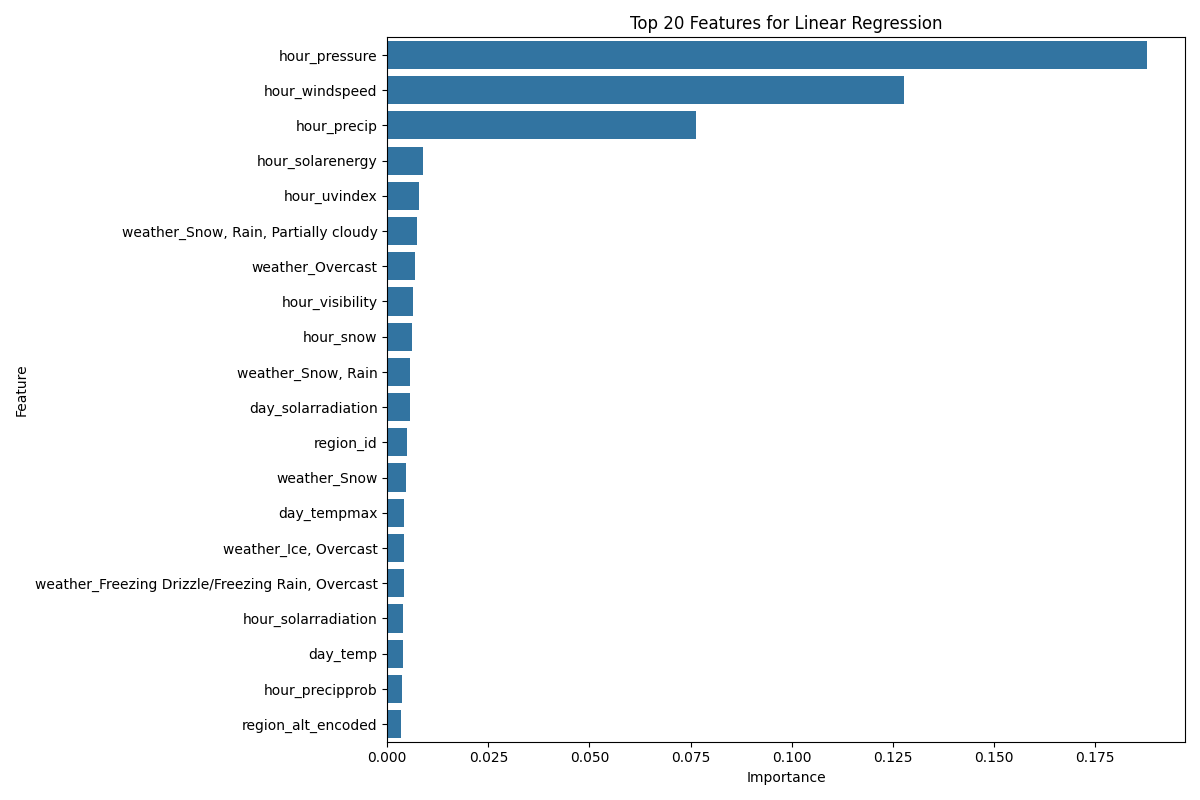

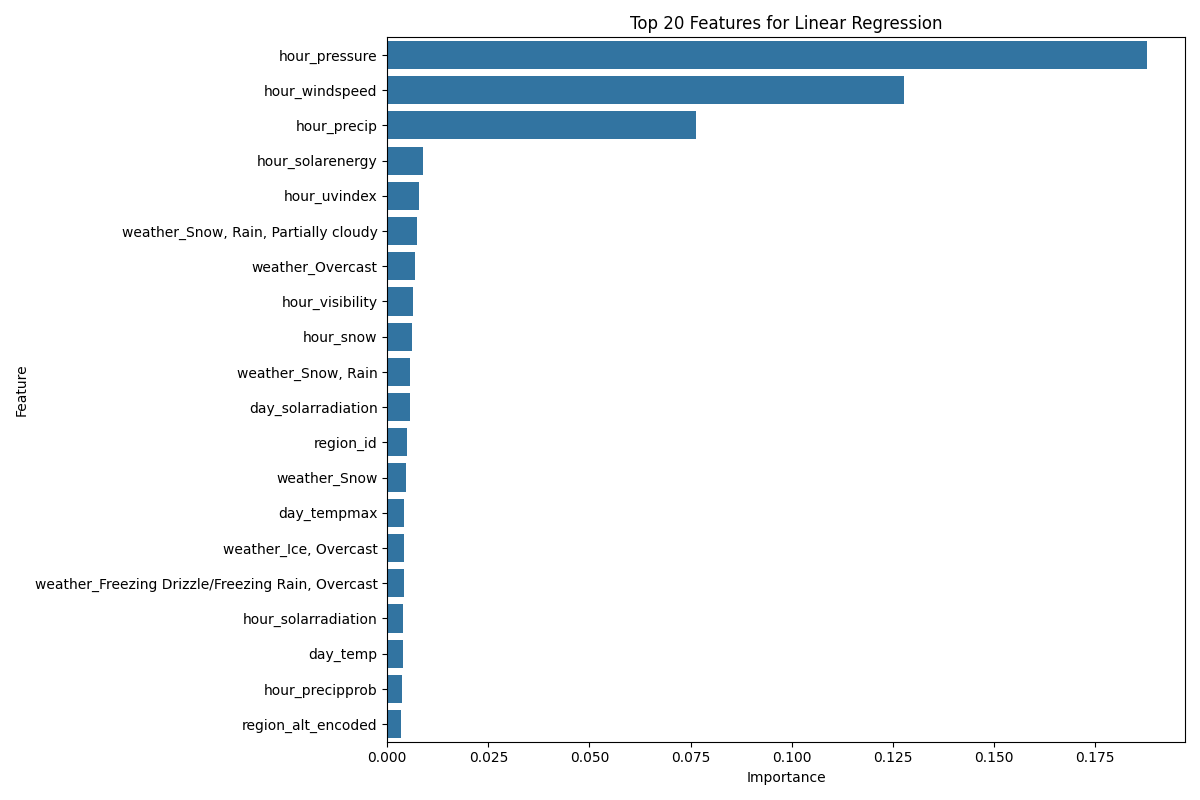

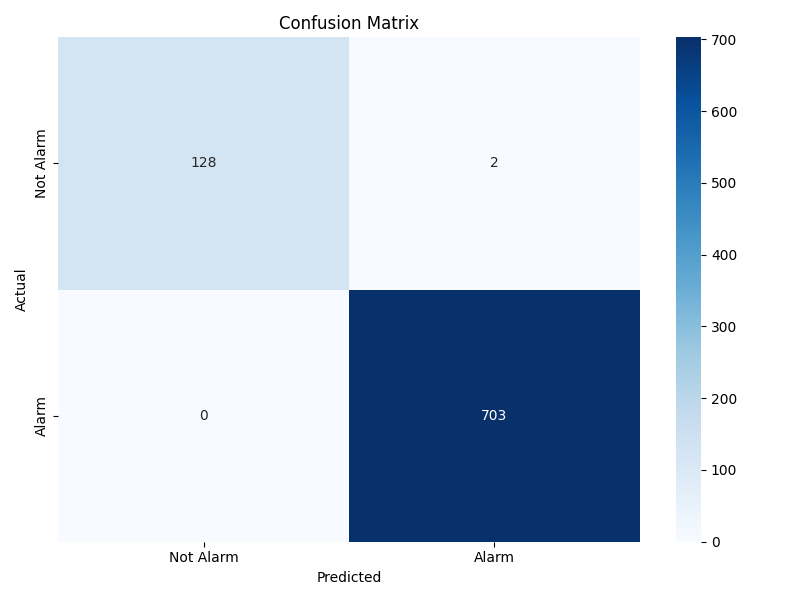

In [31]:
from IPython.display import Image, display

display(Image('top_features_linear.png'))
display(Image('top_features_linear.png'))
display(Image('confusion_matrix.png'))
